TODO:

Sanity checks in functions |
Regularisation |
Prevent underflow/overflow |
Refactor code to make more streamlined |
Metrics: Precision, Recall, F1 score

In [1]:
import numpy as np
import struct
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [3]:
def flatten_imgs(X):
    n_img = np.shape(X)[0]
    h = np.shape(X)[1]
    w = np.shape(X)[2]
    size_arr = h*w
    return np.reshape(X,(n_img,size_arr))

def one_hot(Y,n_class):
    length = np.shape(Y)[1]
    O = np.zeros((n_class,length))
    for i in range(length):
        j = int(Y[0,i])
        O[j,i] = 1
    return O

def inv_one_hot(O):
    n_class = np.shape(O)[0]
    length = np.shape(O)[1]
    Y = np.zeros((1,length))
    for i in range(length):
        j = np.argmax(O[:,i])
        Y[0,i] = j
    return Y

In [4]:
def normalize(X):
    mean = np.mean(X)
    std =  np.std(X)
    N_X = (X-mean)/(std)
    return N_X

def model_accuracy(H,Y):
    n = np.shape(H)[1]
    err = 0
    for i in range(n):
        if H[0,i]!=Y[0,i]:
            err += 1
    accuracy = (1 - err/n)
    return accuracy

In [5]:
class sigmoid:
    def activate(Z):
        A = 1/(1+np.exp(-Z))
        return A
    
    def diff(self,Z):
        dsig = np.multiply(self.activate(Z),(1-self.activate(Z)))
        return dsig
    
class relu:
    def activate(Z):
        A = Z*(Z>0)
        return A
    
    def diff(self,Z):
        d_rel = 1*(Z>0)
        return d_rel
    
# wrong implementation of leaky
class leaky_relu:
    def activate(Z):
        A = Z if (Z.all()>0.001*Z.all()) else 0.001*Z
        return A
    
    def diff(self,Z):
        d_lrel = 1 if (Z.all()>0.001*Z.all()) else 0.001
        return d_lrel
    
class tanh:
    def activate(Z):
        A = np.tanh(Z)
        return A

    def diff(self,Z):
        d_tanh = 1 - (np.multiply(self.activate(Z),self.activate(Z)))
        return d_tanh
    
class softmax:
    """Compute softmax values for each sets of scores in x."""
    def activate(Z):
        e_Z = np.exp(Z- np.max(Z,axis=0))
        return e_Z / e_Z.sum(axis=0)
    
    def diff(Z):
        return Z
    
class CE_loss:
    def get_loss(H,Y):
        L = -np.mean(np.multiply(Y,np.log(H)))
        return L
    
    def diff(H,Y):
        dZ = H - Y 
        return dZ

Initializations taken from : https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94

In [6]:
#Initialize Matrix
def init_theta(n1,n2,activation):
    #n1 = number of nodes in prev layer (input)
    #n2 = number of nodes in next layer (output)
    if activation in [sigmoid,softmax]:
        M = np.random.randn(n2,n1)*np.sqrt(2./n1)
    elif activation in [relu,leaky_relu] :
        M = np.random.randn(n2,n1)*np.sqrt(1./n1)
    elif activation == tanh:
        M = np.random.randn(n2,n1)*np.sqrt(1./(n1+n2))
    return M

In [7]:
X = read_idx('data/MNIST/train/train-images-idx3-ubyte')
X = flatten_imgs(X)
X = normalize(X)
X = np.transpose(X)

Y = read_idx('data/MNIST/train/train-labels-idx1-ubyte')
Y = np.expand_dims(Y, axis=1)
Y = np.transpose(Y)
Y = one_hot(Y,10)

X_test = read_idx('data/MNIST/test/t10k-images.idx3-ubyte')
X_test = flatten_imgs(X_test)
X_test = normalize(X_test)
X_test = np.transpose(X_test)

Y_test = read_idx('data/MNIST/test/t10k-labels.idx1-ubyte')
Y_test = np.expand_dims(Y_test, axis=1)
Y_test = np.transpose(Y_test)
Y_test = one_hot(Y_test,10)


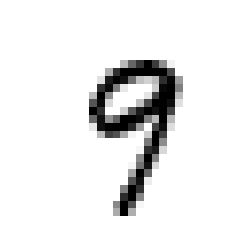

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [11]:
i = 8
plt.imshow(X[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
print(Y[:,i])

In [12]:
class layer:
    def __init__(self, n_prev, n_next, activation):
        self.W = init_theta(n_prev, n_next, activation)
        self.B = init_theta(1, n_next, activation)
        self.activation = activation
        self.V_dW = np.zeros(self.W.shape)
        self.V_dB = np.zeros(self.B.shape)
        
    def forward(self, A0):
        self.Z = np.dot(self.W, A0) + self.B
        self.A = self.activation.activate(self.Z)
        return self.A
    
    def grad(self, dZ, W, A0, m):
        dA = np.dot(W.T, dZ)
        dAdZ = self.activation.diff(self.activation, self.Z)
        self.dZ = np.multiply(dA, dAdZ)
        self.dW = (1./m)*np.dot(self.dZ, A0.T)
        self.dB = (1./m)*(np.sum(self.dZ, axis=1, keepdims=True))
    
    def out_grad(self, dZ, A0, m):
        self.dZ = dZ
        self.dW = (1./m)*np.dot(self.dZ, A0.T)
        self.dB = (1./m)*(np.sum(self.dZ, axis=1, keepdims=True))
        
    def step(self, lr, beta):
        self.V_dW = (beta * self.V_dW + (1. - beta) * self.dW)
        self.V_dB = (beta * self.V_dB + (1. - beta) * self.dB)
        self.W = self.W - lr*self.V_dW
        self.B = self.B - lr*self.V_dB

In [13]:
class MNIST_net:
    def __init__(self, X_size, Y_size, lossfn):
        self.L1 = layer(X_size, 500, relu)
        self.L2 = layer(500, 150, relu)        
        self.L3 = layer(150, Y_size, softmax)
        self.lossfn = lossfn
        
    def f_pass(self, X):
        A1 = self.L1.forward(X)
        A2 = self.L2.forward(A1)
        A3 = self.L3.forward(A2)
        self.H = A3
        return self.H
    
    def back_prop(self,X,Y, batch_size):
        m = batch_size
        self.loss = self.lossfn.get_loss(self.H,Y)
        dZ = self.lossfn.diff(self.H,Y)
        self.L3.out_grad(dZ, self.L2.A, m)
        self.L2.grad(self.L3.dZ, self.L3.W, self.L1.A, m)
        self.L1.grad(self.L2.dZ, self.L2.W, X, m)
    
    def optim(self, lr, beta=0):
        self.L1.step(lr,beta)
        self.L2.step(lr,beta)
        self.L3.step(lr,beta)

In [14]:
def SGD(batch_size,X,Y,model,lr,beta):
    m = np.shape(X)[1]
    for i in range(0,m,batch_size):
        X_batch = X[:,i:i+batch_size]
        Y_batch = Y[:,i:i+batch_size]
        model.f_pass(X_batch)
        model.back_prop(X_batch,Y_batch,batch_size)
        model.optim(lr,beta)
    return model.loss

In [15]:
#Model creation
n_in = np.shape(X)[0]
n_out = np.shape(Y)[0]
mnist_net = MNIST_net(n_in,n_out,CE_loss)

In [16]:
#Hyperparameters
batch_size = 32
lr = 0.075
n_epochs = 10
lr_decay = 0.9
beta = 0.9
data_size = X.shape[1]

epoch:10/10 | Loss:0.0003 | Train Accuracy: 1.0000 | Test_Accuracy:0.9850


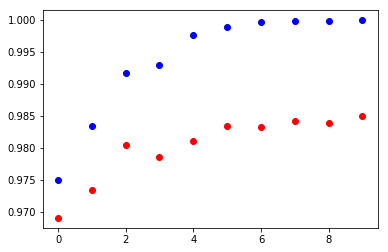

In [17]:
for e in range(n_epochs):
    #shuffle dataset
    np.random.seed(138)
    shuffle_index = np.random.permutation(data_size)
    X, Y = X[:,shuffle_index], Y[:,shuffle_index]
    
    #SGD with momentum
    loss = SGD(batch_size,X,Y,mnist_net,lr,beta)
    
    lr = lr*lr_decay
    
    H = mnist_net.f_pass(X)
    O = inv_one_hot(H)
    L = inv_one_hot(Y)
    tr_acc = model_accuracy(O,L)
    
    H = mnist_net.f_pass(X_test)
    O = inv_one_hot(H)
    L = inv_one_hot(Y_test)
    acc = model_accuracy(O,L)
    
    plt.plot(e,tr_acc, 'bo')
    plt.plot(e,acc,'ro')
    clear_output()
    print(f"epoch:{e+1}/{n_epochs} | Loss:{loss:.4f} | Train Accuracy: {tr_acc:.4f} | Test_Accuracy:{acc:.4f}")

plt.show()